# PA3: 3D IOU (yaw)
实现`半平面交`求带yaw角的3D box的交集, 辅助函数和整体框架已实现, 请填补`half_planes_inter`函数中缺失的部分, 最终效果如下图:
![pa3_show1](./data/pa3_show1.png)
![pa3_show2](./data/pa3_show2.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


`line_inter`求直线AB和CD的交点.

In [2]:
def line_inter(A, B, C, D):
    return A + (B - A) * np.cross(C - A, D - C) / np.cross(B - A, D - C)


`half_planes_inter`接受半平面列表`planes`, 其中每个元素是[2, 2]数组表示一个半平面的起点和终点, 规定半平面为逆时针侧.
1. 对半平面按斜率排序, 并对斜率相同的去重, 这里使用了字典进行去重.
2. 枚举半平面, 若有交点在该半平面外侧则剔除那些交点对应的半平面, 完成后求新加入的半平面与队尾半平面的交点.
3. 枚举完成后再用队首半平面剔除不合法的交点, 最后求队首和队尾的交点.

In [3]:
def half_planes_inter(planes):
    planes_dict = {}
    for pl in planes:
        # Q1: sort half-planes by angle (use np.arctan2)
        theta = np.arctan2(pl[1, 1] - pl[0, 1], pl[1, 0] - pl[0, 0])
        if theta in planes_dict:
            if np.cross(pl[1] - pl[0], planes_dict[theta][0] - pl[0]) < 0:
                planes_dict[theta] = pl
        else:
            planes_dict[theta] = pl
    sorted_planes = [planes_dict[k] for k in sorted(planes_dict.keys())]

    deque, inter = [], []
    for pl in sorted_planes:
        while len(deque) > 1:
            # Q2: condition for discarding the backmost half-plane
            cond1 = np.cross(inter[-1] - pl[0], pl[1] - pl[0]) > 0
            if cond1:
                deque, inter = deque[:-1], inter[:-1]
            else:
                break
        while len(deque) > 1:
            # Q3: ondition for discarding the foremost half-plane
            cond2 = np.cross(inter[0] - pl[0], pl[1] - pl[0]) > 0
            if cond2:
                deque, inter = deque[1:], inter[1:]
            else:
                break
        deque.append(pl)
        if len(deque) > 1:
            inter.append(line_inter(*deque[-1], *deque[-2]))
    while len(deque) > 1:
        # Q4: condition for discarding the backmost half-plane before closing the polygon
        cond3 = np.cross(inter[-1] - deque[0][0], deque[0][1] - deque[0][0]) > 0
        if cond3:
            deque, inter = deque[:-1], inter[:-1]
        else:
            break
    if len(deque) > 2:
        inter.append(line_inter(*deque[0], *deque[-1]))
    if len(inter):
        return np.stack(inter)
    else:
        return np.array([])


运行下方代码可视化BEV结果.

In [4]:
def get_bottom_corners(box3d):
    cx, cy, cz, w, l, h, alpha = box3d
    rot = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
    bottom_corners = np.array(
        [
            [w / 2, -l / 2],
            [w / 2, l / 2],
            [-w / 2, l / 2],
            [-w / 2, -l / 2],
        ]
    ) @ rot.T + np.array([cx, cy])
    return bottom_corners
    
def box3d_to_half_planes(box3d):
    bottom_corners = get_bottom_corners(box3d)
    return [bottom_corners[[i, (i + 1) % 4]] for i in range(4)]

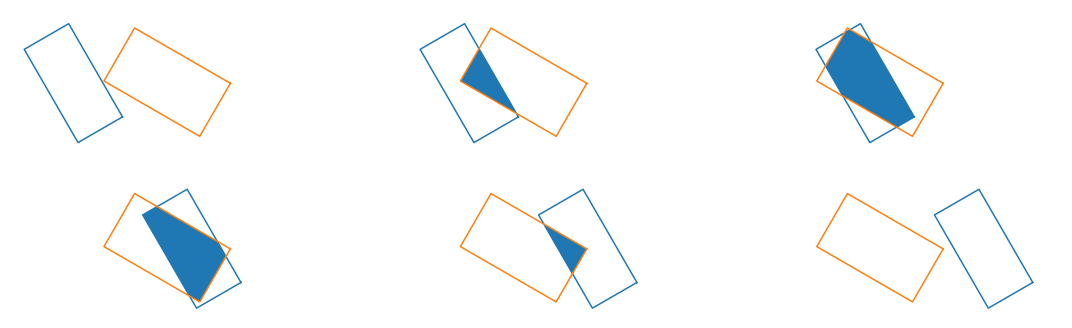

In [5]:
box1 = [-8.3, 2.3, -1.2, 5.2, 10.9, 4.7, np.pi / 6]
box2 = [1.2, 2.4, 0.2, 6.2, 11.2, 3.8, np.pi / 3]
planes1 = box3d_to_half_planes(box1)
planes2 = box3d_to_half_planes(box2)

plt.figure(figsize=(15, 5))
for i in range(0, 24, 4):
    plt.subplot(2, 3, i // 4 + 1)
    plt.xlim([-15, 20])
    plt.ylim([-5, 10])
    plt.gca().set_aspect("equal")
    plt.axis("off")
    edges1 = np.concatenate(planes1) + np.array([i, 0])
    plt.plot(edges1[:, 0], edges1[:, 1])
    edges2 = np.concatenate(planes2)
    plt.plot(edges2[:, 0], edges2[:, 1])
    inter = half_planes_inter([e + np.array([i, 0]) for e in planes1] + planes2)
    if len(inter):
        plt.fill(inter[:, 0], inter[:, 1])
plt.tight_layout()
plt.show()


运行下方代码可视化3D结果.

In [6]:
def draw_poly(ax, x, y, z, c):
    vertices = [list(zip(x, y, z))]
    poly = Poly3DCollection(vertices, alpha=0.1, color=c)
    ax.add_collection3d(poly)


def draw_box3d(ax, box3d, c):
    z_min, z_max = box3d[2] - box3d[5] / 2, box3d[2] + box3d[5] / 2
    bottom_corners = get_bottom_corners(box3d)
    draw_poly(ax, bottom_corners[:, 0], bottom_corners[:, 1], [z_min] * 4, c)
    ax.scatter(bottom_corners[:, 0], bottom_corners[:, 1], [z_min] * 4, color=c)
    draw_poly(ax, bottom_corners[:, 0], bottom_corners[:, 1], [z_max] * 4, c)
    ax.scatter(bottom_corners[:, 0], bottom_corners[:, 1], [z_max] * 4, color=c)
    for i in range(4):
        x = [bottom_corners[i, 0], bottom_corners[(i + 1) % 4, 0], bottom_corners[(i + 1) % 4, 0], bottom_corners[i, 0]]
        y = [bottom_corners[i, 1], bottom_corners[(i + 1) % 4, 1], bottom_corners[(i + 1) % 4, 1], bottom_corners[i, 1]]
        z = [z_min, z_min, z_max, z_max]
        draw_poly(ax, x, y, z, c)

def draw_inter(ax, inter, z_min, z_max, c):
    N = len(inter)
    draw_poly(ax, inter[:, 0], inter[:, 1], [z_min] * N, c)
    ax.scatter(inter[:, 0], inter[:, 1], [z_min] * N, color=c)
    draw_poly(ax, inter[:, 0], inter[:, 1], [z_max] * N, c)
    ax.scatter(inter[:, 0], inter[:, 1], [z_max] * N, color=c)
    for i in range(N):
        x = [inter[i, 0], inter[(i + 1) % N, 0], inter[(i + 1) % N, 0], inter[i, 0]]
        y = [inter[i, 1], inter[(i + 1) % N, 1], inter[(i + 1) % N, 1], inter[i, 1]]
        z = [z_min, z_min, z_max, z_max]
        draw_poly(ax, x, y, z, c)

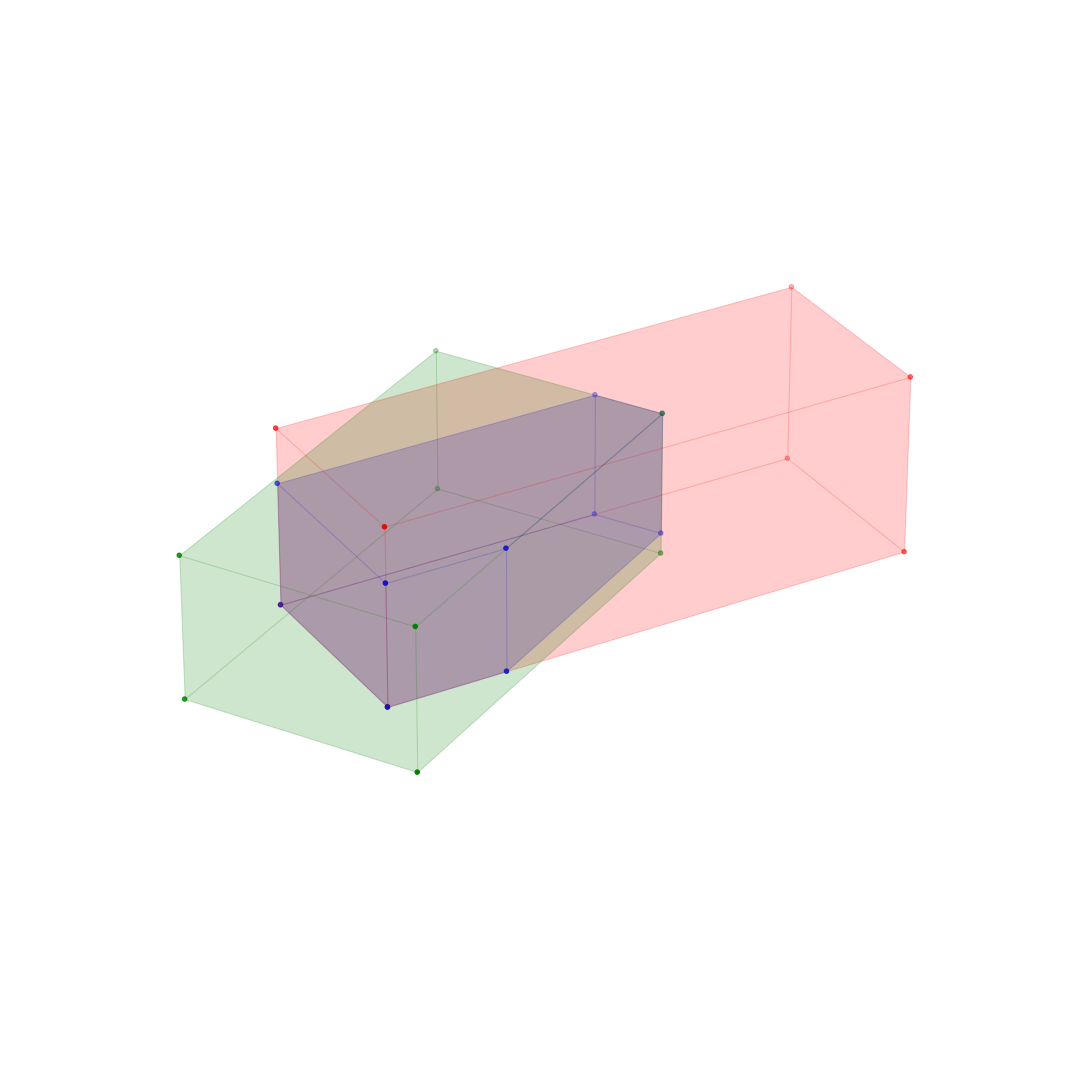

In [7]:
box1 = [0, 6.3, 1.2, 5.2, 13.9, 4.7, np.pi / 6]
box2 = [1.2, 2.4, 0.2, 6.2, 11.2, 3.8, np.pi / 3]
inter = half_planes_inter(box3d_to_half_planes(box1) + box3d_to_half_planes(box2))
z_min = max(box1[2] - box1[5] / 2, box2[2] - box2[5] / 2)
z_max = min(box1[2] + box1[5] / 2, box2[2] + box2[5] / 2)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
ax.axis("off")
draw_box3d(ax, box1, "r")
draw_box3d(ax, box2, "g")
draw_inter(ax, inter, z_min, z_max, "b")
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f"get_{a}lim")() for a in "xyz")])
ax.view_init(30, 0)
plt.tight_layout()
plt.show()
